In [143]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import scipy.optimize
from functools import reduce
import pandas as pd
%matplotlib inline

In [5]:
cd C:\Users\诚明\Desktop\MachineLearning\machine-learning-ex8\ex8

C:\Users\诚明\Desktop\MachineLearning\machine-learning-ex8\ex8


In [303]:
data1 = scipy.io.loadmat('ex8data1.mat')
X = data1['X']
Xcv = data1['Xval']
ycv = data1['yval']

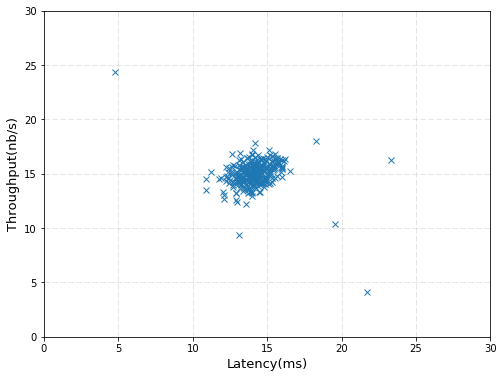

In [304]:
def plotData():
    plt.figure(figsize = (8,6))
    plt.plot(X[:,0], X[:,1], 'x')
    plt.xlim(0,30)
    plt.ylim(0,30)
    plt.xlabel('Latency(ms)', fontsize = 13)
    plt.ylabel('Throughput(nb/s)', fontsize = 13)
    plt.grid(True, linestyle = '--', alpha = 0.4)
plotData()

In [305]:
def estimateGauss(X, multi = False):
    n = X.shape[1]
    m = X.shape[0]
    meanvalue = X.sum(0) / m
    sigmavalue = (X - meanvalue).T.dot(X - meanvalue) / m
    if not multi:
        sigmavalue = np.diag(sigmavalue)
    return meanvalue, sigmavalue

In [306]:
mean, sigma = estimateGauss(X)
mu, sig = estimateGauss(X, multi = True)

In [307]:
def gauss(X, mean, sig):
    n = X.shape[1]
    if sig.ndim == 1:
        sig = np.diag(sig)
    temp1 = np.sqrt((2 * np.pi)**n * np.linalg.det(sig))
    temp2 = np.exp(-np.diag((X - mean).dot(np.linalg.inv(sig)).dot((X - mean).T) / 2))
    p = temp2 / temp1
    return p.reshape((-1,1))

In [308]:
def plotcontour(mean, sig):
    px = np.arange(0, 30, 0.5)
    py = np.arange(0, 30, 0.5)
    meshx, meshy = np.meshgrid(px, py)
    ent = [value.ravel() for value in (meshx, meshy)]
    zpre = np.vstack(ent).T
    z = gauss(zpre, mean, sig).reshape(px.shape[0], px.shape[0])
    cont = plt.contour(meshx, meshy, z, [10**exp for exp in range(-20,0,3)])

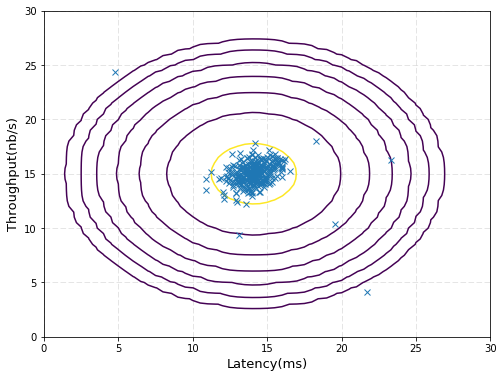

In [309]:
plotData()
plotcontour(mean, sigma)

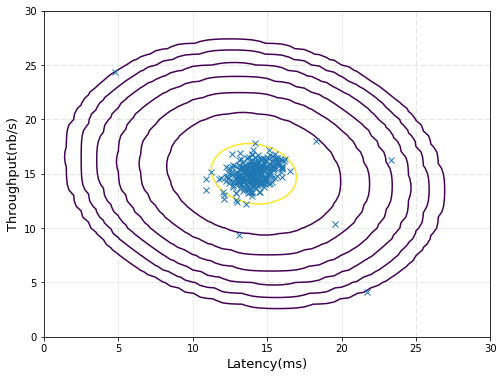

In [310]:
plotData()
plotcontour(mu, sig)

In [311]:
def selectTreshold(pred, ycv):
    stepsize = (np.max(pred) - np.min(pred)) / 1000
    eps = np.arange(np.min(pred), np.max(pred), stepsize)
    F1 = []
    for e in eps:
        predict = set(np.where(pred < e)[0])
        real = set(np.where(ycv == 1)[0])
        total = set(range(len(pred)))
        tp = len(predict & real)
        fp = len(predict - real)
        fn = len((total - predict) & real)
        if ((tp + fp) * (tp + fn)) != 0:
            prec = tp / (tp + fp)
            rec = tp / (tp + fn)
            F1.append(2 * prec * rec / (prec + rec))
        else:
            F1.append(0)
    F1_max = np.nanmax(F1)
    return eps[np.argmax(F1)], F1_max

In [312]:
pred = gauss(Xcv, mean, sigma)
eps, F1 = selectTreshold(pred, ycv)
print("Best eps is %.8f. \nBest F1 score is %.3f" % (eps, F1))

Best eps is 0.00008991. 
Best F1 score is 0.875


In [254]:
pred = gauss(Xcv, mu, sig)
eps, F1 = selectTreshold(pred, ycv)
print("Best eps is %.8f. Best F1 score is %.3f" % (eps, F1))

Best eps is 0.00009066. Best F1 score is 0.875


In [255]:
def plotAnomalies(X, eps):
    pred = gauss(X, mean, sigma)
    ind = np.where(pred < eps)[0]
    plt.scatter(X[ind][:,0], X[ind][:,1], s = 100, facecolors = 'none', edgecolors = 'r', linewidths = 2)

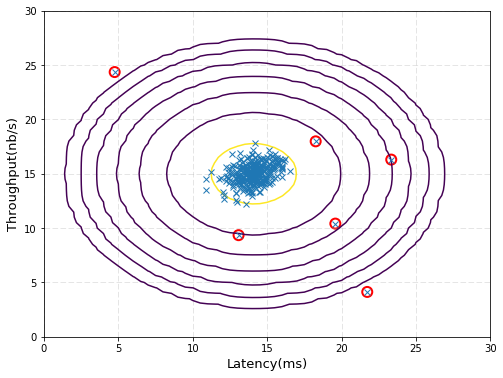

In [256]:
plotData()
plotcontour(mean, sigma)
plotAnomalies(X, eps)

In [177]:
data2 = scipy.io.loadmat('ex8data2.mat')

In [264]:
X = data2['X']
Xcv = data2['Xval']
ycv = data2['yval']
print("shape of X is", X.shape)

shape of X is (1000, 11)


In [301]:
mu, sig = estimateGauss(X, multi = False)
pred_cv = gauss(Xcv, mu, sig)
pred_train = gauss(X, mu, sig)
eps, F1 = selectTreshold(pred_cv, ycv)
num = np.sum(pred_train < eps)
print("Best eps is %s. \nBest F1 score is %.3f. \nNumber of anomalies is %s" % (eps, F1, num))

Best eps is 1.37722889076e-18. 
Best F1 score is 0.615. 
Number of anomalies is 117


## Recommendation Systems

In [6]:
data = scipy.io.loadmat('ex8_movies.mat')
param = scipy.io.loadmat('ex8_movieParams.mat')

In [7]:
R = data['R']
Y = data['Y']
X = param['X']
Theta = param['Theta']
nm, nu = Y.shape

The average rating of the first movie is 3.88


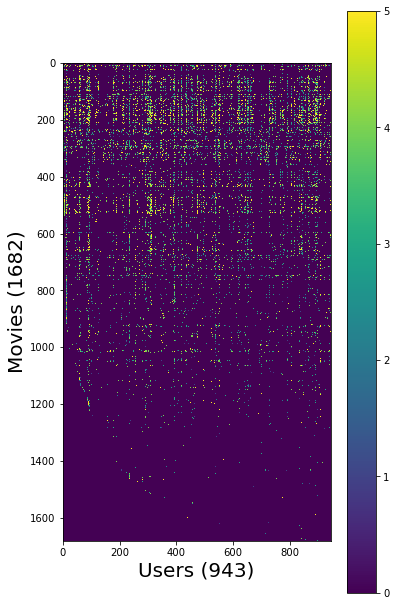

In [8]:
s_ave = np.mean(Y[0][Y[0] != 0])
print("The average rating of the first movie is %.2f" % s_ave)

fig = plt.figure(figsize=(6,6*(1682/943)))
plt.imshow(Y)
plt.colorbar()
plt.ylabel('Movies (%d)'%nm,fontsize=20)
plt.xlabel('Users (%d)'%nu,fontsize=20)

In [9]:
def flattenparams(X, Theta):
    return np.concatenate((X.flatten(),Theta.flatten()))

In [10]:
def reshapeparams(flattened_XandTheta, nu, nm, nf):
    X = flattened_XandTheta[:(nf*nm)].reshape((nm, nf))
    Theta = flattened_XandTheta[(nf*nm):].reshape((nu, nf))
    return X, Theta

In [316]:
def costfunc(params, Y, R, nu, nm, nf, lam = 0):
    X, Theta = reshapeparams(params, nu, nm, nf)
    temp = X.dot(Theta.T) * R - Y
    cost = np.sum(temp**2) / 2
    cost += lam / 2 * sum(sum(Theta**2)) 
    cost += lam / 2 * sum(sum(X**2))
    return float(cost)    

In [317]:
nu = 4
nm = 5
nf = 3
X = X[0:nm, 0:nf]
Theta = Theta[0:nu, 0:nf]
Y = Y[0:nm, 0:nu]
R = R[0:nm, 0:nu]
cost1 = costfunc(flattenparams(X, Theta), Y, R, nu, nm, nf)
cost2 = costfunc(flattenparams(X, Theta), Y, R, nu, nm, nf, lam = 1.5)
print("Lambda = 0: %.5f   Lambda = 1.5: %.5f" % (cost1, cost2))

Lambda = 0: 74.71290   Lambda = 1.5: 107.76467


In [318]:
def gradient(params, Y, R, nu, nm, nf, lam = 0):
    X, Theta = reshapeparams(params, nu, nm, nf)
    temp = X.dot(Theta.T) * R - Y
    delta_Jx = temp.dot(Theta) + lam * X
    delta_Jtheta = temp.T.dot(X) + lam * Theta
    return flattenparams(delta_Jx, delta_Jtheta)

In [319]:
def checkGradient(params, Y, R, nu, nm, nf, lam = 0):
    e = 0.0001
    param_len = len(params)
    grad = gradient(params, Y, R, nu, nm, nf, lam)
    for i in range(10):
        eps = np.zeros(param_len)
        idx = np.random.randint(0, param_len)
        eps[idx] = e
        J1 = costfunc(params + eps, Y, R, nu, nm, nf, lam)
        J2 = costfunc(params - eps, Y, R, nu, nm, nf, lam)
        num_grad = (J1 - J2) / 2 / e
        print("Numeric: %.6f   Gradient: %.6f   Diff: %s \n" % (num_grad, grad[idx], num_grad - grad[idx]))

In [320]:
checkGradient(flattenparams(X, Theta), Y, R, nu, nm, nf)

Numeric: 3.064119   Gradient: 3.064119   Diff: -1.02295949489e-11 

Numeric: -0.677013   Gradient: -0.677013   Diff: 5.00821606408e-12 

Numeric: 1.609467   Gradient: 1.609467   Diff: -8.13189515725e-11 

Numeric: 0.000000   Gradient: 0.000000   Diff: 0.0 

Numeric: 16.087116   Gradient: 16.087116   Diff: -2.93347568459e-11 

Numeric: 0.000000   Gradient: 0.000000   Diff: 0.0 

Numeric: 0.000000   Gradient: 0.000000   Diff: 0.0 

Numeric: 0.000000   Gradient: 0.000000   Diff: 0.0 

Numeric: 27.287562   Gradient: 27.287562   Diff: 1.53832502292e-11 

Numeric: 0.000000   Gradient: 0.000000   Diff: 0.0 



In [321]:
checkGradient(flattenparams(X, Theta), Y, R, nu, nm, nf, lam = 1.5)

Numeric: -6.748031   Gradient: -6.748031   Diff: 7.01447788742e-11 

Numeric: 6.186487   Gradient: 6.186487   Diff: 2.82627254933e-11 

Numeric: 0.767051   Gradient: 0.767051   Diff: 2.99260616288e-11 

Numeric: -0.333070   Gradient: -0.333070   Diff: 5.8848759199e-11 

Numeric: -0.178502   Gradient: -0.178502   Diff: -1.08391629006e-10 

Numeric: -5.131041   Gradient: -5.131041   Diff: -1.63193902836e-11 

Numeric: 28.476918   Gradient: 28.476918   Diff: -3.70441455289e-11 

Numeric: -0.333070   Gradient: -0.333070   Diff: 5.8848759199e-11 

Numeric: 2.585053   Gradient: 2.585053   Diff: -5.61408697308e-11 

Numeric: -0.333070   Gradient: -0.333070   Diff: 5.8848759199e-11 



In [322]:
with open('movie_ids.txt', 'rb') as f:
    file = f.read().decode('latin-1')

In [323]:
file = file.split('\n')
file = [file[i].split(" ", maxsplit = 1) for i in range(len(file))]
idx = pd.Series(file).apply(lambda x: x[0])
name = pd.Series(file).apply(lambda x: x[-1])

In [324]:
my_ratings = np.zeros((1682,1))
my_ratings[0]   = 4
my_ratings[97]  = 2
my_ratings[6]   = 3
my_ratings[11]  = 5
my_ratings[53]  = 4
my_ratings[63]  = 5
my_ratings[65]  = 3
my_ratings[68]  = 5
my_ratings[182] = 4
my_ratings[225] = 5
my_ratings[354] = 5

In [325]:
R = data['R']
Y = data['Y']
X = param['X']
Theta = param['Theta']
nf = 10

In [326]:
my_r = my_ratings.copy()
my_r[my_r > 0] = 1
my_r[my_r == 0] = 0
R = np.hstack((R, my_r))
Y = np.hstack((Y, my_ratings))
nm, nu = Y.shape

In [410]:
def normalizeRatings(Y, R):
    mu = np.sum(Y, axis = 1) / np.sum(R, axis = 1)
    mu = mu.reshape((-1,1))
    Y_norm = Y - mu
    return Y_norm, mu
Y_norm, mu = normalizeRatings(Y, R)

In [414]:
Theta = np.random.randn(nu, nf)
X = np.random.randn(nm, nf)
flatten = flattenparams(X, Theta)

lam = 10
params = scipy.optimize.fmin_cg(costfunc, flatten, fprime = gradient, args = (Y, R, nu, nm, nf, lam),\
                               maxiter=50, disp=True, full_output=True)

         Current function value: 72946.295775
         Iterations: 50
         Function evaluations: 76
         Gradient evaluations: 76


In [415]:
X, Theta = reshapeparams(params[0], nu, nm, nf)
pred = X.dot(Theta.T)[:,-1]
prediction = pred + mu.flatten()
rating = [round(float(x),1) for x in prediction]

In [416]:
rating_idx = np.argsort(rating)[::-1]
for i in range(10):
    print("movie name: %s     rating: %s" % (name[rating_idx[i]], rating[rating_idx[i]]))

movie name: Shawshank Redemption, The (1994)     rating: 8.4
movie name: Schindler's List (1993)     rating: 8.3
movie name: Titanic (1997)     rating: 8.2
movie name: Star Wars (1977)     rating: 8.2
movie name: Raiders of the Lost Ark (1981)     rating: 8.2
movie name: Braveheart (1995)     rating: 8.0
movie name: Silence of the Lambs, The (1991)     rating: 8.0
movie name: Good Will Hunting (1997)     rating: 8.0
movie name: Usual Suspects, The (1995)     rating: 8.0
movie name: Empire Strikes Back, The (1980)     rating: 7.9
